In [ ]:
# first download the needed data
# I hosted all the files in a GCS bucket and gave it public read access
# and temporarily public write access, but I will change that once I am finished
# to ensure that no one stores unwanted files in my bucket
!gsutil cp -r gs://fourth-brain-course-files/* /content/ 
!unzip data.zip 
!mv Data data

In [275]:
# Function for saving data in GCS
# somewhat hacky but will do for now
import logging 

def save_in_gcs(path_to_dir, multi_thread = False):
  command = f"gsutil cp -r {path_to_dir} gs://fourth-brain-course-files/"
  if multi_thread:
    command = f"gsutil -m cp -r {path_to_dir} gs://fourth-brain-course-files/"
    
  result = os.system(command)
  if result:
    logging.warning("Unable to store data in GCS. Write permissions may have been revoked.")
  
  return result

# Data Processing

In [3]:
# these commands may be needed for the cv2 package to work
# sudo apt update
# sudo apt install libgl1-mesa-glx

In [235]:
import os
from typing import *
import shutil
from pathlib import Path
import json
from collections import Counter

import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.semi_supervised import LabelSpreading
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

sns.set()
data_dir = "data"
train_data_dir = Path(os.path.join(data_dir, "train"))
test_data_dir = Path(os.path.join(data_dir, "test"))
train_images_dir = Path(os.path.join(train_data_dir, "train"))
test_images_dir = Path(os.path.join(test_data_dir, "test"))

In [5]:
df = pd.read_csv(train_data_dir / "train.csv")

In [6]:
# get a basic idea of what the csv datat looks like
df.head()

,filename,opacity,diabetic retinopathy,glaucoma,macular edema,macular degeneration,retinal vascular occlusion,normal
0,c24a1b14d253.jpg,0,0,0,0,0,1,0
1,9ee905a41651.jpg,0,0,0,0,0,1,0
2,3f58d128caf6.jpg,0,0,1,0,0,0,0
3,4ce6599e7b20.jpg,1,0,0,0,1,0,0
4,0def470360e4.jpg,1,0,0,0,1,0,0


In [7]:
# Some statistics about the data, though they are not very useful since
# we are looking at binary encoded data, but still goot to look at
df.describe()

,opacity,diabetic retinopathy,glaucoma,macular edema,macular degeneration,retinal vascular occlusion,normal
count,3435.000000,3435.000000,3435.000000,3435.000000,3435.000000,3435.000000,3435.000000
mean,0.446288,0.219796,0.173799,0.150218,0.167103,0.128093,0.152838
std,0.497179,0.414169,0.378992,0.357337,0.373122,0.334242,0.359884
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
# get some info about the data types, non-null counts. 
# Looks like no missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3435 entries, 0 to 3434
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   filename                    3435 non-null   object
 1   opacity                     3435 non-null   int64 
 2   diabetic retinopathy        3435 non-null   int64 
 3   glaucoma                    3435 non-null   int64 
 4   macular edema               3435 non-null   int64 
 5   macular degeneration        3435 non-null   int64 
 6   retinal vascular occlusion  3435 non-null   int64 
 7   normal                      3435 non-null   int64 
dtypes: int64(7), object(1)
memory usage: 214.8+ KB


In [9]:
# rename the columns to not have any spaces
df.columns = ['filename', 'opacity', 'diabetic_retinopathy', 'glaucoma', 'macular_edema', 'macular_degeneration', 'retinal_vascular_occlusion', 'normal']

We are interested in classifying diabetic retinopaty and glaucoma vs normal. I will be chosing to go with a multi-class classification proble, and I will be using deep convolutional network. I will discuss the architecture and other choices further in the notebook.

One thing I will note is that instead of throwing away everything else, let's add a 4th class and call it "other". The rationale behind this is that this way the model might learn features that help it tell what "None of the above" may look like and hence improve performance. 

Let's add an additional column, that we will call **label**. Normal will be assigned 0, glaucoma 1, dr - 2 and every other myopathy will be 3

**UPDATE**
I have tried the approach of having a 4th class, but I was unable to get good performance from the model. For that reason, I will try removing those entries alltogether and see how that affects performance. 


In [10]:
# initialize with all 3s, this way we only need to modify 
# the labels of the diseases we are interested in classifying
class_labels = {
    'normal': 0,
    'glaucoma': 1,
    'diabetic_retinopathy': 2,
}

# we will set things to -1 by default so that 
# we can easily drop rows that we don't need
df['label'] = -1. * np.ones(df.shape[0])

In [11]:
for class_name, label in class_labels.items():
  df.loc[(df[class_name] == 1), 'label'] = int(label)
df.label = df.label.astype(np.int16)
df = df.drop(df[df.label == -1.].index)

In [12]:
# count how many we have in each class
# it looks like classes 0, 1 are balanced 
# however, class 2 has about 50% more data than the other two
# we need to look out for this when training and examining the metrics 
# because we may get good accuracy overall, from the model just predicting 
# the dominant class
df.label.value_counts()

2    755
1    578
0    525
Name: label, dtype: int64

In [13]:
# To mitigate this issue right away we will subsample class 2
# to have a number of values that is the average of the two other classes

subsampled_df = df[df.label == 2].sample(n=(525 + 578)//2)
no_other_df = df[df.label != 2]
new_df = pd.concat([no_other_df, subsampled_df])
new_df.label.value_counts()

1    578
2    551
0    525
Name: label, dtype: int64

For the next step we will create the train/validation splits.

We will use 70% as the training data and 30% as the validation data

In [14]:
# use a trick to not have to do complicated index manipulations
# set seed to get the same thing each time
mask = np.random.rand(len(new_df)) < 0.7
np.random.shuffle(mask)

train_df = new_df[mask]
val_df = new_df[~mask]

In [15]:
train_df.shape, val_df.shape

((1159, 9), (495, 9))

In [16]:
# let's examine the counts to make sure things are balanced
train_df.label.value_counts()

1    413
2    383
0    363
Name: label, dtype: int64

In [17]:
val_df.label.value_counts()

2    168
1    165
0    162
Name: label, dtype: int64

Now we need to create the data generators. A training and validation data generators to be precise. Since we are dealing with large images (512, 512, 3) we cannot read them into memory. We will use the tensorflow ImageDataGenerator class, which will also handle data augmentation for us. Because we do not have the image tensors in memory, we will use the **flow_from_directory** method. However, before that we will need to save the images in separate folders, depending on what class label they have been assigned. 

In [18]:
# do not touch the original data, we will create a separate directory for this
# the plan is to go through every image file in the dataframe, open it and save it in a new location
# following the pattern grouped_images/<class_label>/<image_name>.jpg

def group_images(dataframe, path_to_directory: str, split_name: str):
    # use the path module for easier manipulation of directories
    grouped_images_dir = Path(f"{path_to_directory}/{split_name}")

    # only do this if the directory does not exist
    # otherwise assume this has already been done
    if not grouped_images_dir.exists():
        os.makedirs(grouped_images_dir)
    # iterate over each image and save in location as described above
    for i, (_, row) in enumerate(dataframe.iterrows()):
        print(f"{i} / {len(dataframe)}", end="\r")
        filename = row.filename
        label = str(int(row.label))
        save_dir = grouped_images_dir / label
        if save_dir.exists() is False:
            save_dir.mkdir()
        
        img = image.load_img(train_images_dir / filename)
        img.save(save_dir / filename)
    print()
    print(f"Stored images in {grouped_images_dir}.")

In [19]:
grouped_images_path = Path("grouped_images")

# remove previous directory to not cause any weird conflicts
if grouped_images_path.exists():
    shutil.rmtree(grouped_images_path)

grouped_images_path.mkdir()

group_images(train_df, grouped_images_path, "train")
group_images(val_df, grouped_images_path, "val")

1158 / 1159
Stored images in grouped_images/train.
494 / 495
Stored images in grouped_images/val.


Now we instantiate the data generator with the data augmentations, such as horizontal and vertical flipping,
zoom, rotation and etc.

In [20]:
def normalize_images(image_tensor):
    """
    This function will make sure that all pixel values in the image are 
    between 0 and 1.0
    """
    return image_tensor / 255.


# Create a Data Generator
train_data_gen_args = dict( 
    rotation_range=10.,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.2,
    channel_shift_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant',
    data_format="channels_last",
    preprocessing_function=normalize_images
)

train_image_datagen = ImageDataGenerator(**train_data_gen_args)
val_image_datagen = ImageDataGenerator(
    preprocessing_function=normalize_images
)

train_gen = train_image_datagen.flow_from_directory(
    grouped_images_path / "train",
    target_size=(512, 512),
    color_mode="rgb",
    batch_size=32
)

val_gen = val_image_datagen.flow_from_directory(
    grouped_images_path / "val",
    target_size=(512, 512),
    color_mode="rgb",
    batch_size=32
)

Found 1159 images belonging to 3 classes.
Found 495 images belonging to 3 classes.


# Building The Model

There are a couple of ideas I have for the model architecture and I briefly discuss some of them.

# 1) DenseNetLike
My attempt at recreating a mini version of the DenseNet121 which has shown good performance on medical scan images. However, I am unable to get the model to converge which leads to me to believe that I made some errors in the architecture. One option would be to use the pre-trained model and see how well that performs.

# 2) AlexNetLike
This is a slightly modified version of the AlexNet model that we created in one of our assignments. The advantage of using that is that we know it at least converges and also the architecture is much simpler. This however, has so far not yielded the best results.

# 3) Using DenseNet121 pretrained on the ImageNet dataset
This may be the easiest way to get quality performance from the model. Since Tensorflow has DenseNet121 as one of the out-of-the box models this may be a way to go. It will require chopping off the top part of the model and training a new classifier head, while keeping the rest of the model weights frozen. 
**UPDATE** It appears that performance is significantly improved when we use a pre-trained DenseNet121. 

In [21]:

# Unable to get this to work, for some reason gradients end up exploding
class DenseNetLike(Sequential):
   def __init__(self, input_shape, num_classes):
      super().__init__(name="dense-net-like")

      self.add(
         layers.Conv2D(
            64, kernel_size=(7,7), strides=2, activation='relu', input_shape=input_shape
         )
      )
      self.add(layers.BatchNormalization())
      self.add(layers.MaxPooling2D(pool_size=(3,3), strides=2))

      self.add_dense_block(64)
      self.add_transition_block(128)
      self.add(layers.BatchNormalization())
      self.add_dense_block(512)
      self.add_transition_block(256)
      self.add(layers.BatchNormalization())
      self.add_dense_block(1024)
      self.add_transition_block(512)
      self.add(layers.BatchNormalization())
      self.add_dense_block(1024)
      self.add(layers.Flatten())
      self.add(layers.Dense(num_classes))
      self.add(layers.Dense(num_classes, activation="softmax"))

      self.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.01),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

   def add_dense_block(self, input_dim, growth_factor=32):
      units = input_dim
      self.add(layers.Dense(units, input_shape=(input_dim,)))
      units += growth_factor
      self.add(layers.Dense(units, activation='tanh'))
      units += growth_factor
      self.add(layers.Dense(units, activation='tanh'))
      units += growth_factor
      self.add(layers.Dense(units, activation='tanh'))
      units += growth_factor
      self.add(layers.Dense(units, activation='tanh'))
      units += growth_factor
      self.add(layers.Dense(units, activation='tanh'))
      units += growth_factor
      self.add(layers.Dense(units, activation='tanh'))

   def add_transition_block(self, filters):
      self.add(layers.Conv2D(filters, kernel_size=(1,1), activation="relu"))
      self.add(layers.MaxPool2D())


class AlexNetLike(Sequential):
   def __init__(self, input_shape, num_classes):
    super().__init__()

    self.add(layers.Conv2D(96, kernel_size=(11,11), strides= 4,
                    padding= 'valid', activation= 'relu',
                    input_shape= input_shape, kernel_initializer= 'he_normal'))
    self.add(layers.BatchNormalization())
    self.add(layers.MaxPooling2D(pool_size=(3,3), strides= (2,2),
                          padding= 'valid', data_format= None))
    
    
    self.add(layers.Conv2D(256, kernel_size=(5,5), strides= 1,
                    padding= 'same', activation= 'relu',
                    kernel_initializer= 'he_normal'))
    self.add(layers.BatchNormalization())
    self.add(layers.MaxPooling2D(pool_size=(3,3), strides= (2,2),
                          padding= 'valid', data_format= None)) 
    

    self.add(layers.Conv2D(384, kernel_size=(3,3), strides= 1,
                    padding= 'same', activation= 'relu',
                    kernel_initializer= 'he_normal'))
    self.add(layers.BatchNormalization())
    
    self.add(layers.Conv2D(384, kernel_size=(3,3), strides= 1,
                    padding= 'same', activation= 'relu',
                    kernel_initializer= 'he_normal'))
    self.add(layers.BatchNormalization())
    
    self.add(layers.Conv2D(256, kernel_size=(3,3), strides= 1,
                    padding= 'same', activation= 'relu',
                    kernel_initializer= 'he_normal'))
    self.add(layers.BatchNormalization())
    
    self.add(layers.MaxPooling2D(pool_size=(3,3), strides= (2,2),
                          padding= 'valid', data_format= None))
    

    self.add(layers.Flatten())
    
    self.add(layers.Dense(num_classes, activation= 'softmax'))

    self.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.01),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    

def pre_trained_dense_net(input_shape, num_classes, name="dense-net"):
  """
  Returns pre-trained dense not on ImageNet dataset
  with a custom classifier head for the purposes of transfer learning.
  """
  base_model = tf.keras.applications.DenseNet121(
      weights='imagenet',include_top=False, pooling='max', input_shape=input_shape
  )

  x = base_model.output
  x = layers.Dropout(0.4)(x)
  output = layers.Dense(num_classes)(x)
  output = layers.Dense(num_classes, activation='softmax')(output)
  model = Model(inputs=base_model.input, outputs=output, name=name)

  for layer in base_model.layers[:-3]:
      layer.trainable = False
  
  model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.01),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  
  return model

In [22]:
model = pre_trained_dense_net(input_shape=(512, 512, 3), num_classes=3)

29089792/29084464 [==============================] - 0s 0us/step


In [23]:
model.summary()

Model: "dense-net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 518, 518, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 256, 256, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 256, 256, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________

In [24]:
# plot the model so we can visualize what is going on
figure_directory = Path("figures")
if not figure_directory.exists():
  figure_directory.mkdir()
path_to_graph = figure_directory / f"{model.name}_05-08-2021.png"
tf.keras.utils.plot_model(model, path_to_graph, show_dtype=True, show_layer_names=True, show_shapes=True);
save_in_gcs(figure_directory)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.687516 to fit



0

# Training The Model

We will use the EarlyStopping callback to make sure that we a) always have the weights from the state of the model that performed best and b) that as things begin to converge the model will stop training.

In [25]:
# If this is set to False will try to load saved weights for model
# Else will train and re-save the weights
SHOULD_TRAIN_MODEL = False

In [26]:
history = None
if SHOULD_TRAIN_MODEL:
  es = EarlyStopping(monitor="val_accuracy", mode="max", min_delta=0.05, restore_best_weights=True, patience=3)
  history = model.fit(train_gen, epochs=10, validation_data=val_gen, callbacks=[es])

In [27]:
weights_path = Path("saved_weights")
if SHOULD_TRAIN_MODEL is False:
  model.load_weights(weights_path / f"{model.name}_weights_05-08-2021.h5")
else:
  # save the model weights so that we can reload them if the kernel stops
  weights_path = Path("saved_weights")
  if not weights_path.exists():
    weights_path.mkdir()

  model.save_weights(weights_path/ f"{model.name}_weights_05-08-2021.h5")
  save_in_gcs(weights_path)

In [28]:
model.evaluate(val_gen)

16/16 [==============================] - 26s 326ms/step - loss: 0.5329 - accuracy: 0.7750


[0.5383468270301819, 0.7696969509124756]

In [29]:
# save the history for later retrieval so that when the GPU is switched off
# we still have access to the metrics
history_directory = Path("history/")
if not history_directory.exists():
    history_directory.mkdir()

if history:
  with open(history_directory / f"{model.name}_history_05-08-2021.json", "w+") as f:
      json.dump(history.history, f)
  save_in_gcs(history_directory)

In [30]:
with open(history_directory / f"{model.name}_history_05-08-2021.json", "r+") as f:
    history = json.load(f)

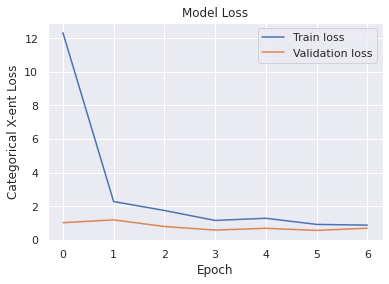

<Figure size 432x288 with 0 Axes>

In [110]:
# plot of the training and validation loss

epochs = range(len(history['loss']))
plt.plot(epochs, history['loss'], label='Train loss')
plt.plot(epochs, history['val_loss'], label='Validation loss')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Categorical X-ent Loss")
plt.legend()
plt.show()
plt.savefig(figure_directory / f"{model.name}_loss_05-08-2021.png")

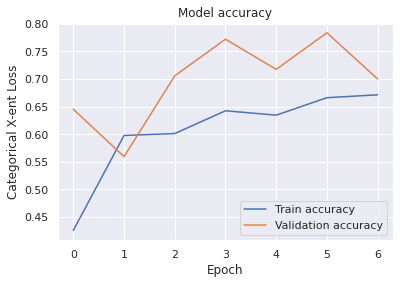

<Figure size 432x288 with 0 Axes>

In [111]:
# plot of the training and validation accuracy

epochs = range(len(history['accuracy']))
plt.plot(epochs, history['accuracy'], label='Train accuracy')
plt.plot(epochs, history['val_accuracy'], label='Validation accuracy')
plt.title("Model accuracy")
plt.xlabel("Epoch")
plt.ylabel("Categorical X-ent Loss")
plt.legend()
plt.show()
plt.savefig(figure_directory / f"{model.name}_accuracy_05-08-2021.png")

In [112]:
save_in_gcs(figure_directory)

0

In [34]:
# get the correct labels as well as the predicted labels

correct_labels = []
predicted_labels = []
val_gen.reset()
batches_seen = 0
print(val_gen.batch_index, val_gen.total_batches_seen)
for i, batch in enumerate(val_gen):
  if batches_seen > 0 and val_gen.batch_index == 0:
    break
  print(val_gen.batch_index, val_gen.total_batches_seen)
  batch_inputs, batch_targets = batch
  correct_labels.extend(np.argmax(batch_targets, axis=1))
  logits = model.predict(batch_inputs)
  predicted_labels_ = np.argmax(logits, axis=1)
  predicted_labels.extend(predicted_labels_)
  batches_seen += 1


0 17
1 18
2 19
3 20
4 21
5 22
6 23
7 24
8 25
9 26
10 27
11 28
12 29
13 30
14 31
15 32


In [35]:
assert len(correct_labels) == len(predicted_labels), "Number of predicted labels is not the same as correct labels"
c = Counter(predicted_labels)

print(f"Unique predictions {set(predicted_labels)}")
print(f"{c}")

Unique predictions {0, 1, 2}
Counter({0: 183, 2: 164, 1: 133})


In [36]:
# generate metrics and save them in a separate file for later retrieval
metrics_directory = Path(f"metrics")
if not metrics_directory.exists():
    metrics_directory.mkdir()

metrics = {
    "accuracy": accuracy_score(correct_labels, predicted_labels),
    "confusion_matrix": confusion_matrix(correct_labels, predicted_labels).tolist()
}

with open(metrics_directory / f"{model.name}_metrics_05-08-2021.json", "w+") as f:
    json.dump(metrics, f)

save_in_gcs(metrics_directory)

0

Accuracy 0.7666666666666667
Confusion matrix 



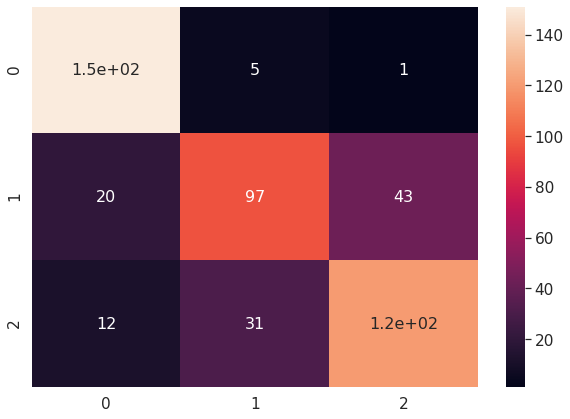

0

<Figure size 432x288 with 0 Axes>

In [124]:
# Let's visualize the metrics
cm = confusion_matrix(correct_labels, predicted_labels).astype(np.int16)
print(f"Accuracy {accuracy_score(correct_labels, predicted_labels)}")
print(f"Confusion matrix \n")

df_cm = pd.DataFrame(cm, range(len(cm)), range(len(cm)))
plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()
plt.savefig(figure_directory / f"{model.name}_cm_05-08-2021.png")
save_in_gcs(figure_directory)

Looking at the results it seems the non-pretrained AlexNetLike model is essentially guessing at random, since the accuracy is 33% and we have a total of 3 classes.

The pre-trained model is performing marginally better at ~38% accuracy which is still a bit surprising given the validation performance.


In [38]:
with open(metrics_directory / f"{model.name}_metrics_05-08-2021.json", "r+") as f:
    metrics = json.load(f)

# Salience Feature Maps

The next stepp will be to generate the salience feature maps and overlay those on top of ther original images in order to see which parts of the image did the model focus on the most when making preditions. We will use the GradCAM approach outlined in this post (https://medium.com/analytics-vidhya/visualizing-activation-heatmaps-using-tensorflow-5bdba018f759) to compute the gradient of the last convolutional layer with respect to the predictions and then generate a heat map based on the value of the derivative. We will then overlay the heatmap on top of the original image and save the new image.

In [39]:
def gradCAM(
    path_to_image:str,
    model: Model,
    layer_name: str,
    intensity=0.5, 
    res=250,
    dim: int = 512,
    out_dir: str = "images_with_features"
):

    root, set_, class_, filename = path_to_image.split("/")

    img = image.load_img(path_to_image, target_size=(dim, dim))
    img_np = image.img_to_array(img)
    img_np = np.expand_dims(img_np, axis=0) # we need to add a dimension to have the batch dimension

    # predict the label
    preds = model.predict(img_np)
    predicted_class = np.argmax(preds, axis=1)

    with tf.GradientTape() as tape:
        last_conv_layer = model.get_layer(layer_name)
        iterate = tf.keras.models.Model(
            [model.inputs], [model.output, last_conv_layer.output]
        )
        model_out, last_conv_layer = iterate(img_np)
        class_out = np.argmax(model_out, axis=1)
        grads = tape.gradient(model_out, last_conv_layer)
        pooled_grads = tf.keras.backend.mean(grads, axis=(0, 1, 2))


    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)
    heatmap = np.maximum(heatmap, 0.0)
    heatmap /= np.max(heatmap)
    heatmap = heatmap.reshape((16, 16))

    img = cv2.imread(path_to_image)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
    img = heatmap * intensity + img


    out_dir = Path(out_dir)
    if not out_dir.exists():
        out_dir.mkdir()
    
    save_path = out_dir / set_ / class_
    if save_path.exists() is False:
        os.makedirs(save_path)
    
    img = cv2.resize(img, (res, res))
    cv2.imwrite(str(save_path / filename), img)

In [40]:
layer_name = "conv5_block16_2_conv"
# path_to_image = "grouped_images/val/0/093e1325c0f5.jpg"
# gradCAM(path_to_image, model, layer_name)

for i, (root, directories, files) in enumerate(os.walk("grouped_images/val")):
    print(i, end="\r")
    if directories != []:
        continue
    for f in files:
        path_to_image = os.path.join(root, f)
        gradCAM(path_to_image, model, layer_name)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


In [41]:
save_in_gcs("images_with_features")

0

### Visualizing the Salience Maps

As the next step we will take a look at a couple of examples of the heat maps from each class to see what patterns may exist in the features that help the model make it's predictions.

In [129]:
def plot_random_images_with_salience_maps(
    class_label: str,
    directory: str = "images_with_features/val",
    n: int = 4,
    seed: int = 10
):
  np.random.seed(seed)
  full_path = Path(directory) / class_label
  files = os.listdir(full_path)
  image_files = []

  for f in files:
    if f.endswith(".jpg") is False:
      continue

    if np.random.uniform(0, 1.0) > 0.5:
      image_path = os.path.join(full_path, f)
      image_files.append(image_path)

    if len(image_files) == n:
      break
  
  fig, axs = plt.subplots(n//2, 2, figsize=(9,9))
  for i, ax in enumerate(axs.flatten()):
    img = cv2.imread(image_files[i])
    ax.imshow(img)
    ax.axis("off")

  label_to_class = {str(v):k for k,v in class_labels.items()}
  fig.suptitle(f"Class {class_label} - {label_to_class.get(class_label)} salience maps", fontsize=16)
  fig.show()
      

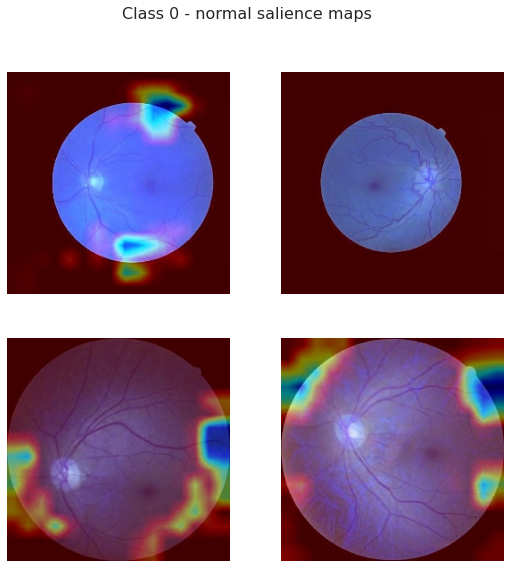

In [130]:
plot_random_images_with_salience_maps("0", seed=9)

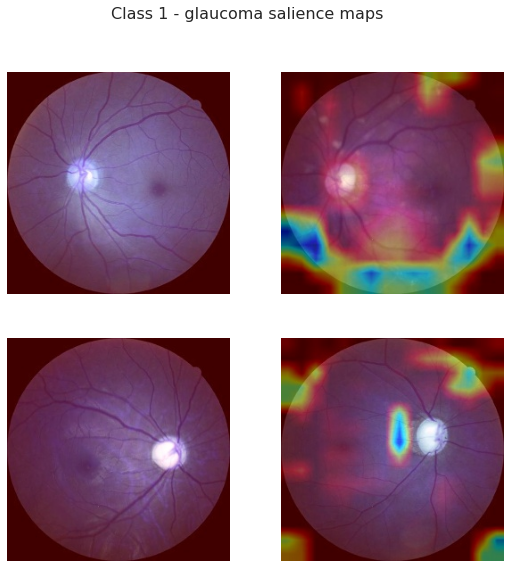

In [131]:
plot_random_images_with_salience_maps("1", seed=9)

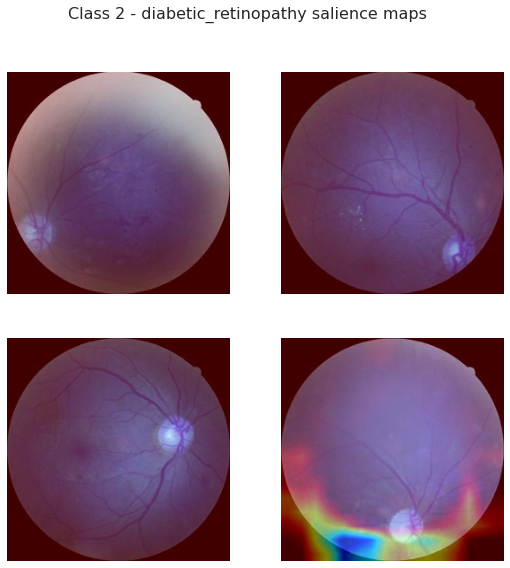

In [132]:
plot_random_images_with_salience_maps("2", seed=7)

## Observations

It appears that for the most part the model docuses on the location where the the blood capillaries meet as well as the outsides of the eyeball. Without additional domain knowledge I am unable to tell if that has any scientific backing to it, but perhaps one thing to consider for our capstone projects would be to reach out to medical professionals and show them those maps and ask whether they think there is any validity to what the model is focusing on.

# Self-Supervised Learning

The first step here will be to use the trained model and obtain the latent representations of the images in our test directory. We will then use lable propogation with those representations to self-label the unlabeled test images. We will then add those to the train dataset, retrain the network and examing the changes in the performance on the validation dataset. 

In [135]:
# create a variable for the directory that contains our test images
path_to_test_images = Path("data/test")

In [191]:
# create a data generator for the test images
# we will not use data augmentation since we want to obtain the embeddings
# for the actual images
# We will however apply the same processing function (normalization)

# we will also need to obtain the embeddings for our training images
# without any augmentation so we will create another generator

def normalize_images(image_tensor):
    """
    This function will make sure that all pixel values in the image are 
    between 0 and 1.0
    """
    return image_tensor / 255.

test_image_gen = ImageDataGenerator(
    preprocessing_function=normalize_images
)

train_image_gen_no_augmentation = ImageDataGenerator(
    preprocessing_function=normalize_images
)

test_gen = val_image_datagen.flow_from_directory(
    path_to_test_images,
    target_size=(512, 512),
    color_mode="rgb",
    batch_size=32
)

train_gen_no_augment = val_image_datagen.flow_from_directory(
    grouped_images_path / "train",
    target_size=(512, 512),
    color_mode="rgb",
    batch_size=32
)

Found 350 images belonging to 1 classes.
Found 1159 images belonging to 3 classes.


In [192]:
# We need create the truncated model that will let us pull out the embeddings
# let's examine the last 10 layers

model.layers[-10:]

In [193]:
# we want the 
# <tensorflow.python.keras.layers.pooling.GlobalMaxPooling2D at 0x7fb60456a890>
# layer, so take everything up to that point

embeddings_model = tf.keras.models.Model(
    model.inputs,
    model.layers[-4].output,
    name=f"{model.name}-embeddings"
  )


In [217]:
# Now that we have the model, let's feed our test images through it
# and save the outputs
test_images_embeddings_dir = Path("embedded_test_images")
if test_images_embeddings_dir.exists() is False:
  test_images_embeddings_dir.mkdir()

test_image_embeddings = np.zeros((test_gen.n, 1024))
batch_size = test_gen.batch_size
test_gen.reset()

for i in range(len(test_gen)):
  images, labels = test_gen[i]
  batch_embeddings = embeddings_model(images)
  test_image_embeddings[i * batch_size: (i + 1) * batch_size] = batch_embeddings

norms = np.linalg.norm(test_image_embeddings, axis=1) 
normalized_test_embeddings = test_image_embeddings / norms[:, np.newaxis]
np.save(test_images_embeddings_dir / f"test_embeddings.npy", test_image_embeddings)
np.save(test_images_embeddings_dir / f"test_embeddings_normed.npy", normalized_test_embeddings)
save_in_gcs(test_images_embeddings_dir)

0

In [223]:
# to do the label propagation we will also need the embedded representations
# of our labelled images

train_images_embeddings_dir = Path("embedded_train_images")
if train_images_embeddings_dir.exists() is False:
  train_images_embeddings_dir.mkdir()

train_image_embeddings = np.zeros((train_gen_no_augment.n, 1024))
batch_size = train_gen_no_augment.batch_size

train_gen_no_augment.reset()
correct_labels = []

for i in range(len(train_gen_no_augment)):
  images, labels = train_gen_no_augment[i]
  batch_embeddings = embeddings_model(images)
  correct_labels.extend(np.argmax(labels, axis=1))
  train_image_embeddings[i * batch_size: (i + 1) * batch_size] = batch_embeddings

# normalize the embeddings to be able to compute similarities
# save both versions
norms = np.linalg.norm(train_image_embeddings, axis=1) 
normalized_train_embeddings = train_image_embeddings / norms[:, np.newaxis]
np.save(train_images_embeddings_dir / f"train_embeddings.npy", train_image_embeddings)
np.save(train_images_embeddings_dir / f"train_embeddings_normed.npy", normalized_train_embeddings)
save_in_gcs(train_images_embeddings_dir)

0

### LabelSpreading Model

Now is the part where we use label propagation to label our unlabelled images. We will first concatenate our unlabelled embeddings with our labelled embeddings and append a -1 as the class label for each of the unlabelled images. We will then use the LabelSpreading api from Sklearn to label said images.

In [239]:
# combine the data
combined_data = np.vstack([train_image_embeddings, test_image_embeddings])
combined_data_normed = np.vstack([normalized_train_embeddings, normalized_test_embeddings])

# keep track of which file is in which position
train_file_name_to_index = { i: f for i,f in enumerate(train_gen_no_augment.filenames)}
test_file_name_to_index = {i:f for i,f in enumerate(test_gen.filenames)}

In [240]:
# sanity check
print(combined_data.shape, train_image_embeddings.shape, test_image_embeddings.shape)
print(combined_data_normed.shape)

(1509, 1024) (1159, 1024) (350, 1024)
(1509, 1024)


In [232]:
# add labels to our correct_labels
combined_labels = correct_labels.copy()
combined_labels.extend([-1 for _ in range(len(test_file_name_to_index))])
len(combined_labels)

1509

In [250]:
# instantiate the model
lp_model = LabelSpreading()

In [251]:
# using the normed data helps avoid numerical overflows
lp_model = lp_model.fit(combined_data_normed, combined_labels)

In [255]:
# obtain the predictions
predicted_labels = lp_model.transduction_[-len(test_file_name_to_index):]

In [267]:
!rm -rf train_test_grouped_images

In [272]:
# now let's create a new directory with our grouped images which will include the 
# newly labelled data
# use the filenames that we saved

extended_grouped_images_dir = Path("train_test_grouped_images/train")
if extended_grouped_images_dir.exists() is False:
  os.makedirs(extended_grouped_images_dir)

# first copy our newly labelled test images
for index, filepath in test_file_name_to_index.items():
  filename = filepath.split("/")[-1]
  predicted_label = predicted_labels[index]
  path_to_image = test_data_dir / "test" / filename
  new_dir = extended_grouped_images_dir / str(predicted_label)
  if not new_dir.exists():
    new_dir.mkdir()

  new_path_to_image = new_dir / filename
  img = cv2.imread(str(path_to_image))
  cv2.imwrite(str(new_path_to_image), img)

In [273]:
# now move our existing train images
for index, filepath in train_file_name_to_index.items():
  path_to_image = grouped_images_path / "train" / filepath
  new_path_to_image = extended_grouped_images_dir / filepath
  img = cv2.imread(str(path_to_image))
  cv2.imwrite(str(new_path_to_image), img)

In [276]:
save_in_gcs("train_test_grouped_images", multi_thread=True)

0

Now that we have saved those images it is time to retrain the model with the new data and then re-evaluate its performance

In [277]:
def normalize_images(image_tensor):
    """
    This function will make sure that all pixel values in the image are 
    between 0 and 1.0
    """
    return image_tensor / 255.


# Create a Data Generator
args = dict( 
    rotation_range=10.,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.2,
    channel_shift_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant',
    data_format="channels_last",
    preprocessing_function=normalize_images
)

combined_train_data_gen = ImageDataGenerator(**args)
val_image_datagen = ImageDataGenerator(preprocessing_function=normalize_images)

combined_train_generator = combined_train_data_gen.flow_from_directory(
    extended_grouped_images_dir,
    target_size=(512, 512),
    color_mode="rgb",
    batch_size=32
)

val_gen = val_image_datagen.flow_from_directory(
    grouped_images_path / "val",
    target_size=(512, 512),
    color_mode="rgb",
    batch_size=32
)

Found 1509 images belonging to 3 classes.
Found 495 images belonging to 3 classes.


In [281]:
model = pre_trained_dense_net(input_shape=(512, 512, 3), num_classes=3)
SHOULD_TRAIN_MODEL = True

In [282]:
history = None
if SHOULD_TRAIN_MODEL:
  es = EarlyStopping(monitor="val_accuracy", mode="max", min_delta=0.05, restore_best_weights=True, patience=3)
  history = model.fit(train_gen, epochs=10, validation_data=val_gen, callbacks=[es])
  
weights_path = Path("saved_weights")
if SHOULD_TRAIN_MODEL is False:
  model.load_weights(weights_path / f"{model.name}_lp_weights_05-08-2021.h5")
else:
  # save the model weights so that we can reload them if the kernel stops
  weights_path = Path("saved_weights")
  if not weights_path.exists():
    weights_path.mkdir()

  model.save_weights(weights_path/ f"{model.name}_lp_weights_05-08-2021.h5")
  save_in_gcs(weights_path)

Epoch 1/10
37/37 [==============================] - 84s 2s/step - loss: 19.2912 - accuracy: 0.3554 - val_loss: 3.0997 - val_accuracy: 0.5919
Epoch 2/10
37/37 [==============================] - 75s 2s/step - loss: 4.2483 - accuracy: 0.5364 - val_loss: 0.5627 - val_accuracy: 0.7636
Epoch 3/10
37/37 [==============================] - 73s 2s/step - loss: 1.8302 - accuracy: 0.6114 - val_loss: 0.6013 - val_accuracy: 0.7212
Epoch 4/10
37/37 [==============================] - 70s 2s/step - loss: 1.3116 - accuracy: 0.6285 - val_loss: 0.5728 - val_accuracy: 0.7394
Epoch 5/10
37/37 [==============================] - 71s 2s/step - loss: 0.9618 - accuracy: 0.6500 - val_loss: 0.5247 - val_accuracy: 0.7636


In [284]:
# save the history for later retrieval so that when the GPU is switched off
# we still have access to the metrics
history_directory = Path("history/")
if not history_directory.exists():
    history_directory.mkdir()

if history:
  with open(history_directory / f"{model.name}_lp_history_05-08-2021.json", "w+") as f:
      json.dump(history.history, f)
  save_in_gcs(history_directory)

In [285]:
with open(history_directory / f"{model.name}_lp_history_05-08-2021.json", "r+") as f:
    history = json.load(f)

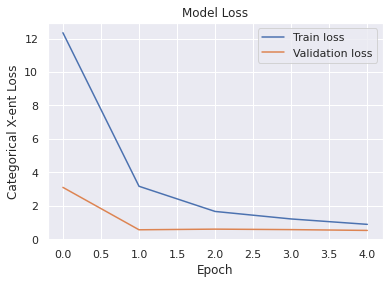

<Figure size 432x288 with 0 Axes>

In [286]:
# plot of the training and validation accuracy
epochs = range(len(history['loss']))
plt.plot(epochs, history['loss'], label='Train loss')
plt.plot(epochs, history['val_loss'], label='Validation loss')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Categorical X-ent Loss")
plt.legend()
plt.show()
plt.savefig(figure_directory / f"{model.name}_lp_loss_05-08-2021.png")

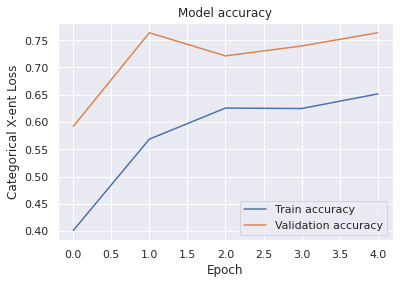

<Figure size 432x288 with 0 Axes>

In [287]:
# plot of the training and validation loss

epochs = range(len(history['accuracy']))
plt.plot(epochs, history['accuracy'], label='Train accuracy')
plt.plot(epochs, history['val_accuracy'], label='Validation accuracy')
plt.title("Model accuracy")
plt.xlabel("Epoch")
plt.ylabel("Categorical X-ent Loss")
plt.legend()
plt.show()
plt.savefig(figure_directory / f"{model.name}_lp_accuracy_05-08-2021.png")

In [288]:
# get the correct labels as well as the predicted labels

correct_labels = []
predicted_labels = []
val_gen.reset()
for index in range(len(val_gen)):
  batch_inputs, batch_targets = val_gen[index]
  correct_labels.extend(np.argmax(batch_targets, axis=1))
  logits = model.predict(batch_inputs)
  predicted_labels_ = np.argmax(logits, axis=1)
  predicted_labels.extend(predicted_labels_)


In [289]:
assert len(correct_labels) == len(predicted_labels), "Number of predicted labels is not the same as correct labels"
c = Counter(predicted_labels)

print(f"Unique predictions {set(predicted_labels)}")
print(f"{c}")

Unique predictions {0, 1, 2}
Counter({0: 189, 2: 156, 1: 150})


In [290]:
# generate metrics and save them in a separate file for later retrieval
metrics_directory = Path(f"metrics")
if not metrics_directory.exists():
    metrics_directory.mkdir()

metrics = {
    "accuracy": accuracy_score(correct_labels, predicted_labels),
    "confusion_matrix": confusion_matrix(correct_labels, predicted_labels).tolist()
}

with open(metrics_directory / f"{model.name}_lp_metrics_05-08-2021.json", "w+") as f:
    json.dump(metrics, f)

save_in_gcs(metrics_directory)

0

Accuracy 0.7636363636363637
Confusion matrix 



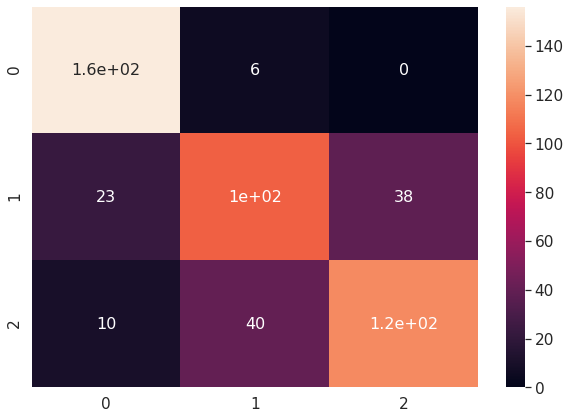

0

<Figure size 432x288 with 0 Axes>

In [291]:
# Let's visualize the metrics
cm = confusion_matrix(correct_labels, predicted_labels).astype(np.int16)
print(f"Accuracy {accuracy_score(correct_labels, predicted_labels)}")
print(f"Confusion matrix \n")

df_cm = pd.DataFrame(cm, range(len(cm)), range(len(cm)))
plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()
plt.savefig(figure_directory / f"{model.name}_lp_cm_05-08-2021.png")
save_in_gcs(figure_directory)

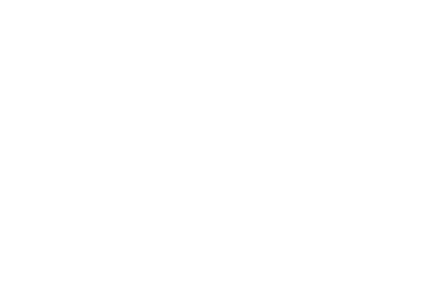

In [292]:
from IPython.display import Image
Image('figures/dense-net_cm_05-08-2021.png')

### Observation

While the model performance does not seem to have improved too much, it does appear that the model got more of the images from class 1, i.e. the Glaucoma myopathy correct.

# Key Takeaways
* Using a pre-trained network offered a huge boost, nearly 40% accuracy improvement
* Including the "other" images as a separate class seemed to hinder the performance of the model
* I was unfrotunately unable to get my own version of the DenseNet to converge, hence was not able to try it out
* Using label propagation seems to have improved the model's ability to classify images of the glaucoma class, but did not offer a significant boost in overall performance.
* The above may be due to some issues with data processing
* For future directions (capstone project) I will need to have a much more organizer, robust and consisent data processing pipeline to ensure that no minor bugs cause problems along the way, since as this midterm showed it's very hard to actually find where the problems are.